logmel 64x256
force lowest representation to less than 500 vals

In [1]:
from utils import *
import array 

from pydub import AudioSegment
import tensorflow as tf

from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, Flatten, GlobalMaxPooling1D, MaxPooling2D, Activation, BatchNormalization, GlobalAveragePooling2D, GlobalMaxPool2D, concatenate, Dense, Dropout
from keras.optimizers import Adam
from tensorflow.python.keras.utils import to_categorical

from keras.layers import Input, GRU, RepeatVector, BatchNormalization, TimeDistributed, Conv1D
from keras.layers import GlobalAveragePooling1D, LSTM, MaxPooling1D, CuDNNLSTM, Bidirectional
from keras import backend as K
from keras.layers import  Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape
import keras
from keras.layers import AveragePooling1D, UpSampling1D, Conv2DTranspose

from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt


%matplotlib inline

Using TensorFlow backend.


In [2]:
POSSIBLE_LABELS = 'yes no up down left right on off stop go silence unknown'.split()
id2name = {i: name for i, name in enumerate(POSSIBLE_LABELS)}
name2id = {name: i for i, name in id2name.items()}
len(id2name)

12

#### load raw auidos into memory for faster processing

In [18]:
%%time 

train_df = pickle.load( open("cache/train_df_64_256.pik","rb"))
valid_df = pickle.load( open("cache/valid_df_64_256.pik","rb"))
silent_df = pickle.load(open("cache/silent_df_64_256.pik","rb"))
unknown_df = pickle.load(open("cache/unknown_df_64_256.pik","rb"))
test_df =  pickle.load(open("cache/test_df_64_256.pik","rb"))

CPU times: user 17.4 s, sys: 34.3 s, total: 51.7 s
Wall time: 5min 16s


In [3]:
full_train_df = pickle.load( open("cache/full_train_64x256.pik","rb"))


In [72]:
test_df =  pickle.load(open("cache/test_df_64_256.pik","rb"))

### generators
train gen will also sample from test files

In [19]:
train_df.reset_index(inplace=True,drop=True)
valid_df.reset_index(inplace=True,drop=True)
unknown_df.reset_index(inplace=True,drop=True)
silent_df.reset_index(inplace=True,drop=True)

In [20]:
(train_df.shape[0]*1.1 + unknown_df.shape[0] + test_df.shape[0])/64

3415.1796875

In [21]:
# there are a couple of records with all 'pixel' values set to 1.0, they will cause 'inf' loss durin training, so removing them
means = test_df.raw.apply(lambda x: x[0].mean() ) 
test_df = test_df[  means < 0.0]

In [22]:
def train_generator(train_batch_size):
    while True:
        
        this_train = train_df.groupby('label_id').apply(lambda x: x.sample(n = 2000))
        extra_data_size = int(this_train.shape[0]* 0.1)
        this_train = pd.concat([test_df , #.sample(this_train.shape[0]),
                                silent_df.sample(extra_data_size),
                                this_train,
                                unknown_df]) #.sample(this_train.shape[0])],axis=0)
        
        this_train.reset_index(drop=True,inplace=True)
#         print this_train.columns
        
        shuffled_ids = random.sample(range(this_train.shape[0]), this_train.shape[0])
        
        for start in range(0, len(shuffled_ids), train_batch_size):
            x_batch = []
            end = min(start + train_batch_size, len(shuffled_ids))
            i_train_batch = shuffled_ids[start:end]
            for i in i_train_batch:
                x_batch.append(this_train.loc[i,'raw'].T)
                
            x_batch = 1.- np.array(x_batch)/-80.
#             y_batch = to_categorical(y_batch, num_classes = len(POSSIBLE_LABELS))
            yield x_batch, x_batch

In [73]:
next(train_generator(64))[0].shape

(64, 64, 256)

In [51]:
train_df.shape[0]*3

63315

In [23]:
def valid_generator(val_batch_size):
    while True:
        ids = list(range(valid_df.shape[0]))
        for start in range(0, len(ids), val_batch_size):
            x_batch = []
            end = min(start + val_batch_size, len(ids))
            i_val_batch = ids[start:end]
            for i in i_val_batch:
                x_batch.append(valid_df.loc[i,'raw'].T)

            x_batch = 1.- np.array(x_batch)/-80.
            yield x_batch, x_batch

In [6]:
next(valid_generator(64))[0].shape

(64, 64, 256)

In [8]:
#a common practice is to choose a filter size in time which spans 2/3 o

In [4]:
from keras.layers import Input, GRU, RepeatVector, BatchNormalization, TimeDistributed, Conv1D
from keras import backend as K
from keras.layers import  Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape




# inputs = Input(shape=(timesteps, input_dim))
# conv2d = Conv1D(64,1,activation='relu')(inputs)
# encoded = GRU(latent_dim,return_sequences=True)(conv2d)
# encoded = GRU(latent_dim,return_sequences=True)(encoded)
# encoded = TimeDistributed(Dense(latent_dim, activation='sigmoid'))(encoded)

# # decoded = RepeatVector(timesteps)(encoded)
# decoded = GRU(latent_dim, return_sequences=True)(encoded)
# decoded = GRU(latent_dim, return_sequences=True)(decoded)
# decoded = TimeDistributed(Dense(input_dim, activation='sigmoid'))(decoded)

# model = Model(inputs, decoded)

In [15]:


# #original
# x = BatchNormalization()(x)
# x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
# x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)

# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

# encoded = MaxPooling2D((2, 2), padding='same', name="latent")(x)


# x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)


# x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
# x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)

# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
# decoded  = Reshape((timesteps, input_dim))(decoded)

# model = Model(input_img, decoded)
# # autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [26]:
# input_img = Input(shape=(timesteps, input_dim))  # adapt this if using `channels_first` image data format

# x = Reshape((timesteps, input_dim,1))(input_img)

# x = Conv2D(64, (10, 10), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
# x = MaxPooling2D((2, 2), padding='same')(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# encoded = MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)

# # at this point the representation is (4, 4, 8) i.e. 128-dimensional

# x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(64, (10, 10), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
# decoded  = Reshape((timesteps, input_dim))(decoded)

# model = Model(input_img, decoded)
# # autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [127]:
timesteps, input_dim , latent_dim = 64,256, 128

def batch_relu(x):
    x = BatchNormalization()(x)    
    x = Activation('relu')(x)
    
    return x 


input_img = Input(shape=(timesteps, input_dim))  # adapt this if using `channels_first` image data format

x = Reshape((timesteps, input_dim,1))(input_img)

x = Conv2D(64, (10, 10), padding='same')(x)
x = batch_relu(x)
x = MaxPooling2D((2, 4), padding='same')(x)

x = Conv2D(32, (5, 5), padding='same')(x)
x = batch_relu(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), padding='same')(x)
x = batch_relu(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), padding='same')(x)
x = batch_relu(x)
encoded = MaxPooling2D((2, 2), padding='same', name='bottleneck')(x)

# at this point the representation is (4, 5, 16) i.e. 320 params

x = Conv2D(8, (3, 3), padding='same')(encoded)
x = batch_relu(x)
x = UpSampling2D((2, 2))(x)
# x = Conv2DTranspose(8, (3, 3), activation ='relu', strides = 2, padding='same')(x)


x = Conv2D(16, (3, 3), padding='same')(x)
x = batch_relu(x)
x = UpSampling2D((2, 2))(x)
# x = Conv2DTranspose(16, (3, 3), activation ='relu',  strides = 2,padding='same')(x)


x = Conv2D(32, (5, 5), padding='same')(x)
x = batch_relu(x)
# x = Conv2DTranspose(32, (5, 5), activation ='relu', strides = 2,padding='same')(x)

x = UpSampling2D((2, 2))(x)


x = Conv2D(64, (10, 10), padding='same')(x)
x = batch_relu(x)
# x = Conv2DTranspose(64, (10, 10), activation ='relu', strides = (2,4), padding='same')(x)

x = UpSampling2D((2, 4))(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoded  = Reshape((timesteps, input_dim))(decoded)

model = Model(input_img, decoded)


In [128]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

model.compile(optimizer=Adam(lr=1e-3), loss=root_mean_squared_error)

In [129]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 256)           0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 64, 256, 1)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 256, 64)       6464      
_________________________________________________________________
batch_normalization_17 (Batc (None, 64, 256, 64)       256       
_________________________________________________________________
activation_17 (Activation)   (None, 64, 256, 64)       0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 64, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 64, 32)        51232     
__________

In [20]:
model.load_weights("weights/starter_ae_wtest_conv_rmse_c6.hdf5")

In [145]:
# model.load_weights('weights/starter_{}.hdf5'.format(exp_name))
# model.load_weights('weights/starter_ae_lstm_large_withdense_128_with_test.hdf5')
# model.load_weights('weights/starter_ae_wtest_conv_rmse_c5.hdf5'.format(exp_name))
# 

Epoch 8/100
329/329 [==============================] - 30s - loss: 0.5700 - acc: 0.1437 - val_loss: 0.5567 - val_acc: 0.1522

RMSE
latent_dim = 128
Epoch 16/100
329/329 [==============================] - 48s - loss: 0.0966 - acc: 0.2346 - val_loss: 0.0859 - val_acc: 0.2259

latent_dim = 256
Epoch 10/100
329/329 [==============================] - 47s - loss: 0.0946 - acc: 0.2367 - val_loss: 0.0844 - val_acc: 0.2312

latdim: 256, mse
Epoch 11/100
330/329 [==============================] - 50s - loss: 0.0113 - acc: 0.1773 - val_loss: 0.0093 - val_acc: 0.2245

latdim: 256, bxent
330/329 [==============================] - 51s - loss: 0.4866 - acc: 0.1917 - val_loss: 0.5078 - val_acc: 0.1525
Epoch 00011: early stopping


Epoch 00012: reducing learning rate to 0.000999999977648. adadelta bix, conv tiramisu
990/989 [==============================] - 93s - loss: 0.4627 - acc: 0.1618 - val_loss: 0.4635 - val_acc: 0.1526


ae_wtest_conv_rmse_c3, adam, root_mean_squared_error
Epoch 7/100
3300/3300 [==============================] - 388s - loss: 0.1300 - acc: 0.4638 - val_loss: 0.1303 - val_acc: 0.4960

ae_wtest_conv_rmse_c6
Epoch 23/100
3300/3300 [==============================] - 386s - loss: 0.0260 - acc: 0.5283 - val_loss: 0.0263 - val_acc: 0.5537



-- freqconv1d
Epoch 18/100
3300/3300 [==============================] - 162s 49ms/step - loss: 0.0186 - acc: 0.6073 - val_loss: 0.0185 - val_acc: 0.6488

2d convs simple 255
Epoch 11/100
3300/3300 [==============================] - 2638s 799ms/step - loss: 0.0065 - acc: 0.8386 - val_loss: 0.0076 - val_acc: 0.8517

ae_wtest_2dconv_64x256_squeeze_rmse
Epoch 9/100 
3358/3358 [==============================] - 1302s 388ms/step - loss: 0.0507 - val_loss: 0.0528

In [8]:
exp_name = "ae_wtest_2dconv_deconv_64x256_squeeze_rmse"
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1),
             
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=3,
                               verbose=1,
                               epsilon=5e-3,
                               min_lr=1e-5),
             
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/{}.hdf5'.format(exp_name),
                             save_best_only=True,
                             save_weights_only=True)
             
#             ,TensorBoard(log_dir='./logs/logs_{}'.format(exp_name), histogram_freq=0, batch_size=64, write_graph=True)
            ]

In [ ]:
history = model.fit_generator(generator=train_generator(64),
                              steps_per_epoch=3358, #train_df.shape[0]*3/64, #3300, #t
                              epochs=100,
                              callbacks=callbacks,
                              shuffle=True,
                              validation_data=valid_generator(64),
                              validation_steps=int(np.ceil(valid_df.shape[0]/64)))

Epoch 1/100
3358/3358 [==============================] - 2549s 759ms/step - loss: 0.0701 - val_loss: 0.0705
Epoch 2/100
3358/3358 [==============================] - 2542s 757ms/step - loss: 0.0595 - val_loss: 0.0632
Epoch 3/100
3358/3358 [==============================] - 2541s 757ms/step - loss: 0.0560 - val_loss: 0.0572
Epoch 4/100
 137/3358 [>.............................] - ETA: 40:09 - loss: 0.0543

In [12]:
model.load_weights("weights/ae_wtest_2dconv_64x256_squeeze_rmse.hdf5")

In [15]:
model.load_weights('weights/{}.hdf5'.format(exp_name))

In [16]:
t = next(valid_generator(64))[0][20].T

In [130]:
bottleneck = Model(input_img, encoded)


#### actual

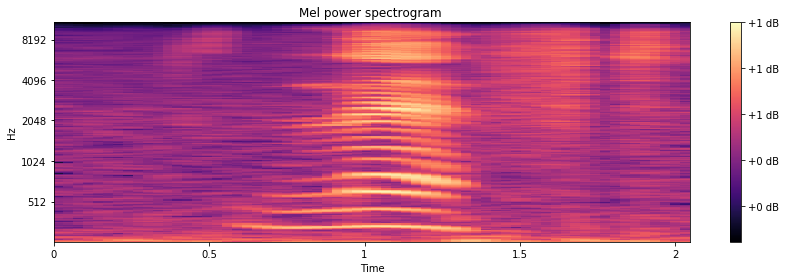

In [17]:
plot_mel(t)

In [18]:
b = model.predict(t.T.reshape(1,t.shape[1],t.shape[0]))[0].T

#### recunstruction (conv2d - deep - squeezed - rmse 0.05 loss)

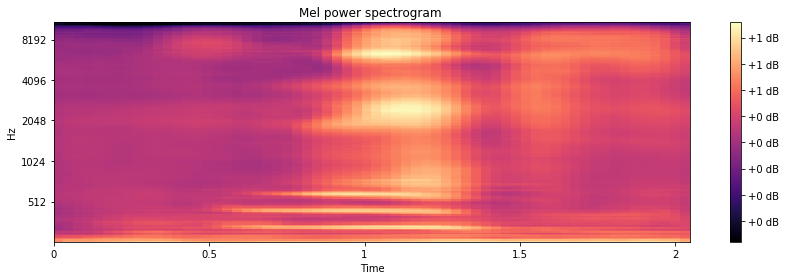

In [19]:
plot_mel(b) #(b-1.)*80

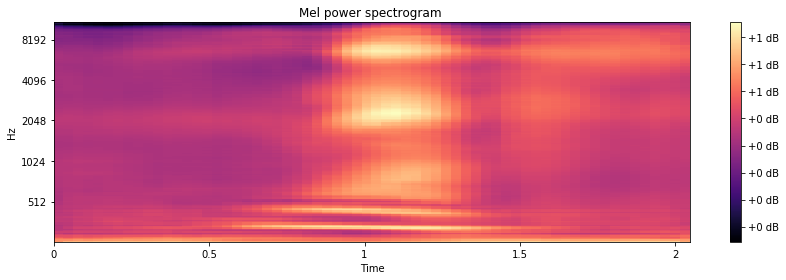

In [66]:
plot_mel(b) #(b-1.)*80

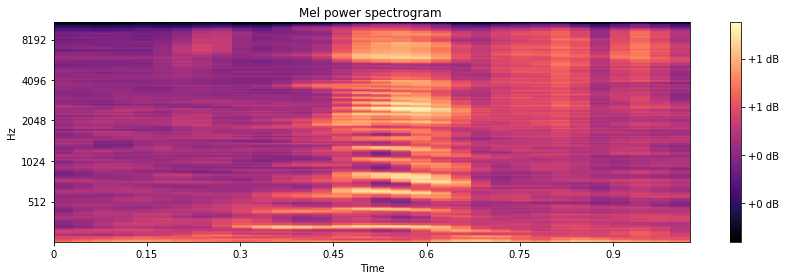

In [24]:
plot_mel(b) #(b-1.)*80

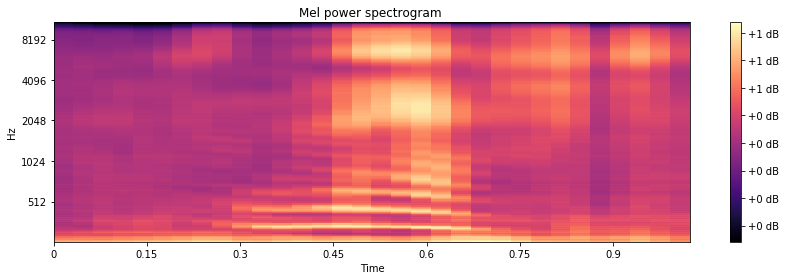

In [84]:
plot_mel(b) #(b-1.)*80

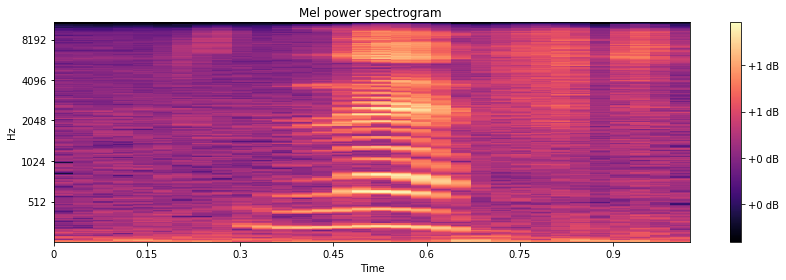

In [68]:
plot_mel(b) #(b-1.)*80

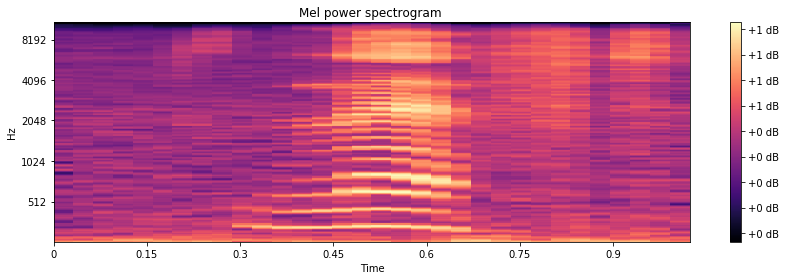

In [27]:
plot_mel(b) #(b-1.)*80

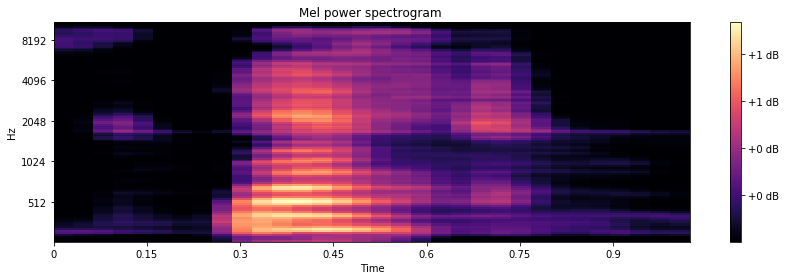

In [169]:
plot_mel(b) #(b-1.)*80

#### conv2d - bix

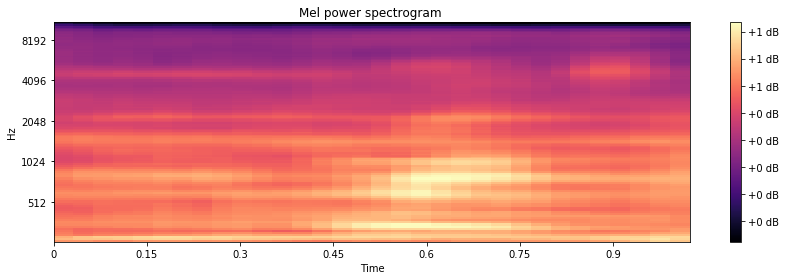

In [331]:
plot_mel(b) #(b-1.)*80

In [293]:
t.shape

(1, 128, 32)

In [14]:
def x_generator(test_df, test_batch_size,augment=False):
    while True:
        ids = list(range(test_df.shape[0]))
        
        for start in range(0, len(ids), test_batch_size):
            x_batch = []
            end = min(start + test_batch_size, len(ids))
            i_test_batch = ids[start:end]

            for i in i_test_batch:
                x_batch.append(test_df.loc[i,'raw'].T)
            
            x_batch = np.array(x_batch)
            x_batch = 1.- np.array(x_batch)/-80.
            yield x_batch


In [16]:
batch_size = 64
train_predictions = bottleneck.predict_generator(x_generator(full_train_df, batch_size), 
                                             int(np.ceil(len(full_train_df)/float(batch_size))), verbose=1)   

1012/1012 [==============================] - 73s 72ms/step


In [28]:
train_predictions.reshape(64721,-1).shape

(64721, 256)

In [37]:
full_train_df.raw[0].shape

(256, 64)

In [38]:
full_train_df.shape

(64721, 5)

In [143]:
predictions = bottleneck.predict_generator(test_generator(64,augment=False), int(np.ceil(len(test_paths)/64.)), verbose=1)

2478/2478 [==============================] - 1230s  


In [ ]:
full_train_df["bottleneck"] = train_predictions.reshape(full_train_df.shape[0],-1).tolist()

In [58]:
len(train_predictions.reshape(full_train_df.shape[0],-1).tolist())

64721

In [60]:
full_train_df.bottleneck  = full_train_df.bottleneck.apply(lambda x: np.array(x))

In [63]:
means = full_train_df.bottleneck.apply(lambda x: np.mean(x))

(array([  2.60000000e+01,   2.23000000e+02,   2.42300000e+03,
          1.38960000e+04,   2.91450000e+04,   1.72000000e+04,
          1.76500000e+03,   4.20000000e+01,   0.00000000e+00,
          1.00000000e+00]),
 array([ 0.87932403,  0.98796669,  1.09660935,  1.205252  ,  1.31389466,
         1.42253732,  1.53117997,  1.63982263,  1.74846529,  1.85710794,
         1.9657506 ]),
 <a list of 10 Patch objects>)

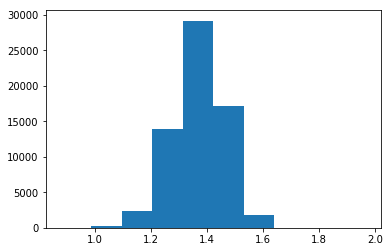

In [64]:
plt.hist(means)

In [70]:
np.mean(full_train_df.bottleneck.iloc[5001])

1.3157577552192379

In [123]:
full_train_df.drop(['raw'],axis=1,inplace=True)

In [124]:
pickle.dump( full_train_df,open("cache/full_train_bottleneck.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)

### test_preds

In [74]:
test_predictions = bottleneck.predict_generator(x_generator(test_df, batch_size), 
                                             int(np.ceil(len(test_df)/float(batch_size))), verbose=1)

2478/2478 [==============================] - 175s 71ms/step


In [76]:
test_df["bottleneck"] = test_predictions.reshape(test_df.shape[0],-1).tolist()

test_df.bottleneck  = test_df.bottleneck.apply(lambda x: np.array(x))

In [121]:
test_df.drop(['raw'],axis=1,inplace=True)

In [122]:
pickle.dump( test_df,open("cache/test_df_bottleneck.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)

### silent_df

In [131]:
silent_df = pickle.load(open("cache/silent_df_64x256.pik","rb"))


In [132]:
silent_preds = bottleneck.predict_generator(x_generator(silent_df, batch_size), 
                                             int(np.ceil(len(silent_df)/float(batch_size))), verbose=1)

7/7 [==============================] - 1s 143ms/step


In [133]:
silent_df["bottleneck"] = silent_preds.reshape(silent_df.shape[0],-1).tolist()

silent_df.bottleneck  = silent_df.bottleneck.apply(lambda x: np.array(x))

In [118]:
silent_df.drop(['raw'],axis=1,inplace=True)

In [119]:
pickle.dump( silent_df,open("cache/silent_df_bottleneck.pik","wb"),protocol=pickle.HIGHEST_PROTOCOL)

In [126]:
silent_df.head()

,label,label_id,user_id,wav_file,bottleneck
0,silence,0,dude,./data/train/audio/silence/dude_miaowing9.wav,"[2.87454342842, 0.486500263214, 2.86737084389,..."
1,silence,0,white,./data/train/audio/silence/white_noise30.wav,"[3.23968219757, 0.368319392204, 3.07114267349,..."
2,silence,0,running,./data/train/audio/silence/running_tap21.wav,"[2.91561746597, 0.451604366302, 2.81829357147,..."
3,silence,0,doing,./data/train/audio/silence/doing_the_dishes48.wav,"[2.60088515282, 0.485310673714, 2.66900038719,..."
4,silence,0,running,./data/train/audio/silence/running_tap23.wav,"[2.90653777122, 0.439174890518, 2.81264305115,..."
